Accessing summary data through MPRester.summary is deprecated. Please use MPRester.materials.summary instead.


Retrieving SummaryDoc documents:   0%|          | 0/6390 [00:00<?, ?it/s]

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` exp

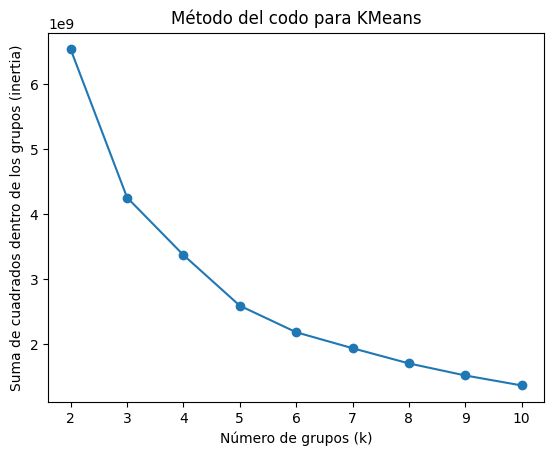

In [2]:
# Importar las bibliotecas necesarias
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from mp_api.client import MPRester
from matminer.data_retrieval.retrieve_MP import MPDataRetrieval
from matminer.featurizers.base import MultipleFeaturizer, StackedFeaturizer
from matminer.featurizers import composition as cf

# Conectar con la base de datos de materials project usando la API de pymatgen
# Reemplaza "YOUR_API_KEY" con tu clave de API obtenida desde el sitio web de materials project
mpr = MPRester("Q4KseBQeiCIFmpyIzcxTaWeQ0DVWzyZf")

# Obtener los datos de materiales que quieres analizar
# En este ejemplo, se obtienen los datos de los óxidos binarios con una energía de formación menor que -1 eV/átomo
# Se seleccionan las propiedades: identificador del material (material_id), fórmula reducida (reduced_cell_formula), energía de formación (formation_energy_per_atom) y volumen (volume)
docs = mpr.summary.search(elements=["Si"], band_gap=(0.0, 1.05),fields=["material_id", "composition","reduced_cell_formula", "formation_energy_per_atom", "volume"])

# Convertir los resultados en un dataframe
df = pd.DataFrame([material.__dict__ for material in docs])

# df = pd.read_csv('todo_mat')
# df = df[0:50]

# Aplicar algún método de reducción de dimensionalidad o selección de características para simplificar los datos
# En este ejemplo, se usa la función auto_featurize de matminer para generar automáticamente características a partir de la composición química
# Se usan las siguientes clases de características: ElementProperty, Stoichiometry, ValenceOrbital, IonProperty y ElementFraction
feature_classes = [cf.ElementProperty.from_preset("magpie"), cf.Stoichiometry(), cf.ValenceOrbital(props=["avg"]), cf.IonProperty(), cf.ElementFraction()]
featurizer = MultipleFeaturizer(feature_classes)
X = featurizer.fit_transform(df['composition'])

X_df = pd.DataFrame(X)
X_df = X_df.dropna(axis=1) # Eliminar las columnas con valores nulos

# Elegir un algoritmo de clustering adecuado para los datos
# En este ejemplo, se usa el algoritmo KMeans de sklearn para agrupar los datos en k grupos según su similitud
# Se elige el valor de k usando el método del codo, que consiste en variar el valor de k y observar el cambio en la suma de cuadrados dentro de los grupos (inertia)
ks = range(2, 11) # Probar valores de k entre 2 y 10
inertias = [] # Lista para guardar los valores de inertia para cada k
for k in ks:
    # Crear el modelo de KMeans con k grupos
    model = KMeans(n_clusters=k, random_state=0)
    # Entrenar el modelo con los datos
    model.fit(X_df)
    # Añadir el valor de inertia a la lista
    inertias.append(model.inertia_)

# Graficar los valores de k e inertia
plt.plot(ks, inertias, "-o")
plt.xlabel("Número de grupos (k)")
plt.ylabel("Suma de cuadrados dentro de los grupos (inertia)")
plt.title("Método del codo para KMeans")
plt.show()


The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


Coeficiente de silueta: 0.55 con 3 clusters
Índice Davies-Bouldin: 0.80 con 3 clusters
Coeficiente de silueta: 0.55 con 4 clusters
Índice Davies-Bouldin: 0.76 con 4 clusters
Coeficiente de silueta: 0.48 con 5 clusters
Índice Davies-Bouldin: 0.80 con 5 clusters
Coeficiente de silueta: 0.48 con 6 clusters
Índice Davies-Bouldin: 0.87 con 6 clusters
Coeficiente de silueta: 0.47 con 7 clusters
Índice Davies-Bouldin: 0.90 con 7 clusters
Coeficiente de silueta: 0.48 con 8 clusters
Índice Davies-Bouldin: 0.87 con 8 clusters


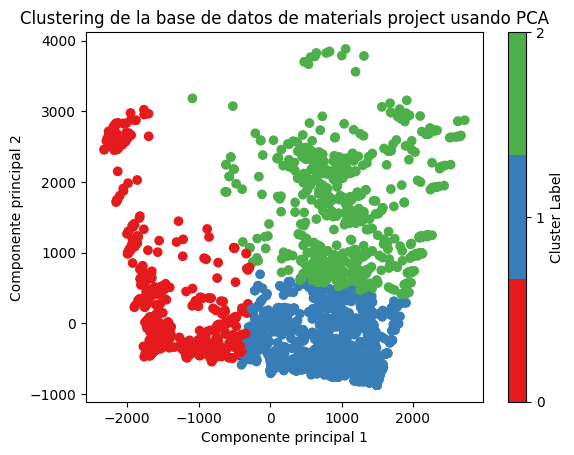

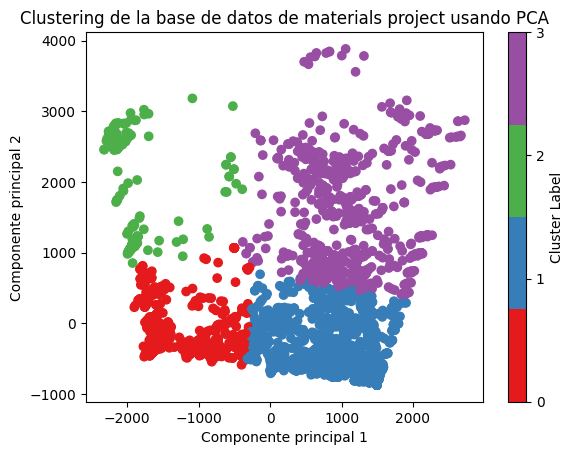

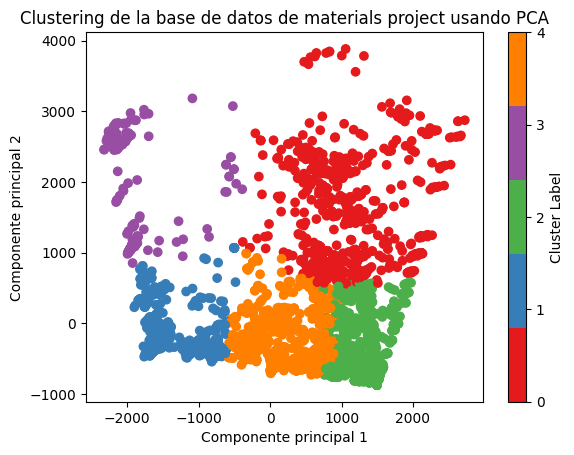

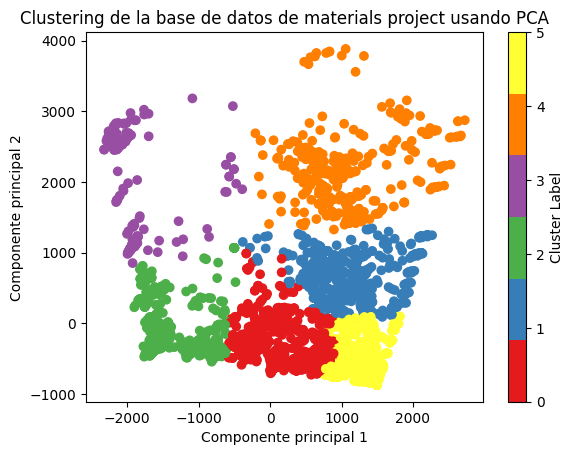

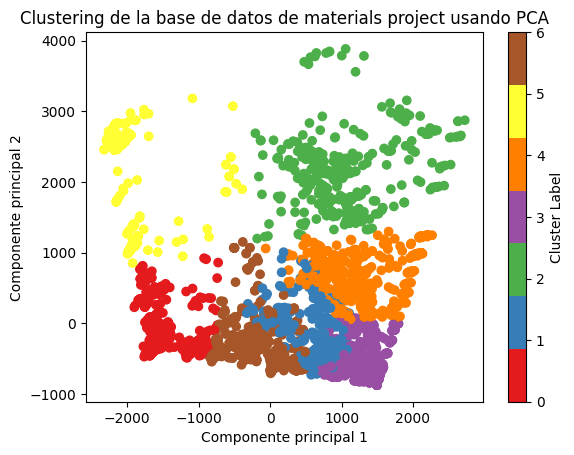

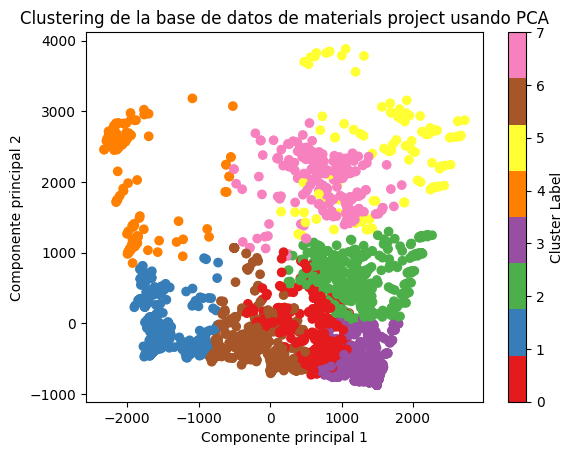

In [26]:
from matplotlib.colors import ListedColormap
# Según la gráfica, se observa que el valor óptimo de k es 6, ya que a partir de ese punto la curva se suaviza
# Por lo tanto, se crea el modelo de KMeans con k=6 y se obtienen las etiquetas de los grupos asignados a cada material
models = []
labels_all = []
for i in range(3,9):
    model = KMeans(n_clusters=i, random_state=0)
    model.fit(X_df)
    labels = model.labels_
    models.append(model)
    labels_all.append(labels)

# Evaluar el resultado del clustering usando alguna medida de calidad
# En este ejemplo, se usan el coeficiente de silueta y el índice Davies-Bouldin, que miden la cohesión y la separación de los grupos
# El coeficiente de silueta varía entre -1 y 1, siendo 1 el mejor valor posible
# El índice Davies-Bouldin varía entre 0 e infinito, siendo 0 el mejor valor posible
for i in range(0,len(labels_all)):
    silhouette = silhouette_score(X_df, labels_all[i])
    davies_bouldin = davies_bouldin_score(X_df, labels_all[i])
    print(f"Coeficiente de silueta: {silhouette:.2f} con {i+3} clusters")
    print(f"Índice Davies-Bouldin: {davies_bouldin:.2f} con {i+3} clusters")

# Visualizar el resultado del clustering usando alguna técnica de proyección o gráfica
# En este ejemplo, se usa el análisis de componentes principales (PCA) para reducir la dimensionalidad de los datos a dos dimensiones y graficar los puntos con colores según su grupo

# Choose a colormap (e.g., "Set1")
cmap = plt.get_cmap("Set1")

for i in range(0,len(labels_all)):

    # Define the number of clusters (k)
    num_clusters = len(np.unique(labels_all[i]))

    # Create a ListedColormap with distinct colors for each cluster
    cluster_cmap = ListedColormap(cmap.colors[:num_clusters])

    pca = PCA(n_components=3)
    X_pca = pca.fit_transform(X_df)
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels_all[i], cmap=cluster_cmap)
    plt.xlabel("Componente principal 1")
    plt.ylabel("Componente principal 2")
    plt.title("Clustering de la base de datos de materials project usando PCA")
    plt.colorbar(scatter, ticks=range(num_clusters), label='Cluster Label')
    plt.show()

In [20]:
len(np.unique(labels_all[4]))

7

In [4]:
from sklearn.metrics.pairwise import euclidean_distances
import numpy as np


def sim_matrix(features, labels):
    useful_labels = labels >= 0

    # primero ordenamos los datos en base al cluster que pertencen
    indices = np.argsort(labels[useful_labels])
    sorted_features = features[useful_labels][indices]

    # calculamos las distancias entre todos los puntos
    d = euclidean_distances(sorted_features, sorted_features)
    return d

def plot(data, model, is_model = True):
    if is_model:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))

        fig.suptitle(f"{model.__class__.__name__}")

        ax1.scatter(data[:,0], data[:,1], c=model.labels_)

        dist = sim_matrix(data, model.labels_)
        im = ax2.imshow(dist, cmap="jet")
        fig.colorbar(im, ax=ax2)
    else:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))

        fig.suptitle('Clustering Jerárquico')

        ax1.scatter(data[:,0], data[:,1], c = model)

        dist = sim_matrix(data, model)
        im = ax2.imshow(dist, cmap="jet")
        fig.colorbar(im, ax=ax2)


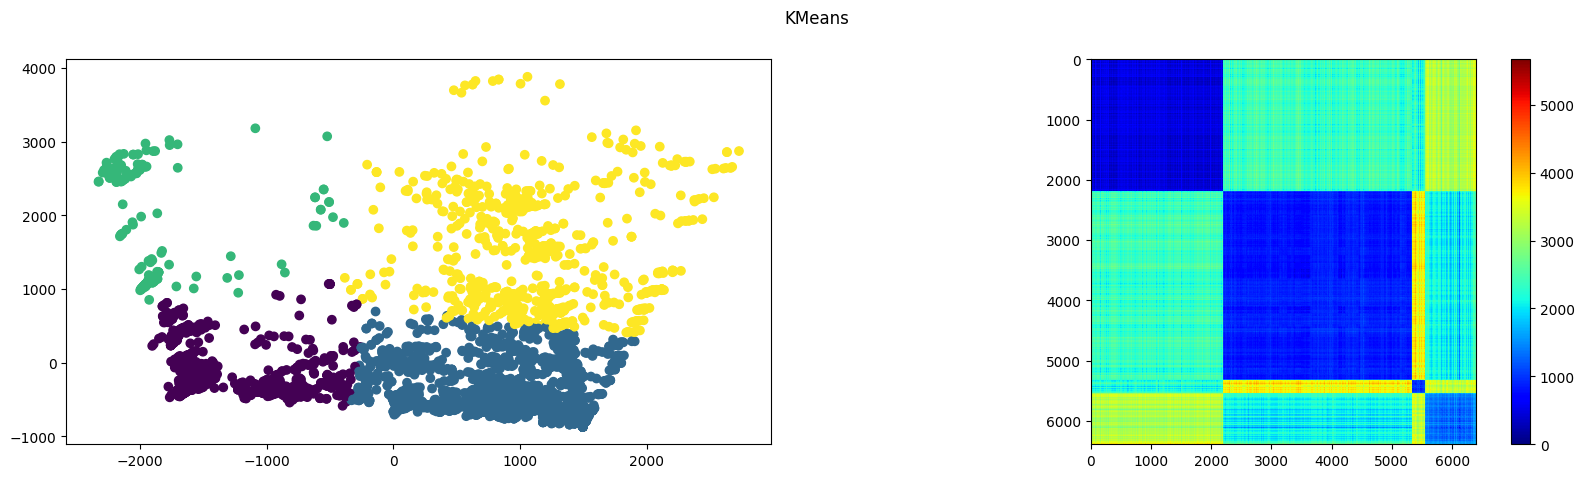

In [5]:
plot(X_pca, models[1])

In [27]:
print(np.unique(models[1].labels_))

[0 1 2 3]


In [28]:
# Obtenemos el cluster (label) asignado a cada material
# Así podremos hacer EDA de los materiales en cada cluster
df['cluster'] = models[1].labels_ # Añadir una columna con los clusters asignados
cluster0 = df[df['cluster'] == 0] 
cluster1 = df[df['cluster'] == 1]
cluster2 = df[df['cluster'] == 2]
cluster3 =  df[df['cluster'] == 3]

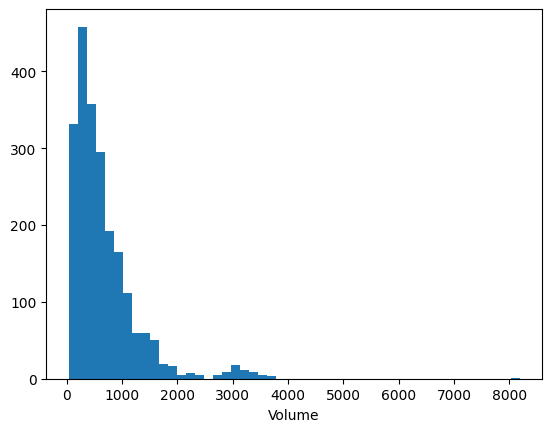

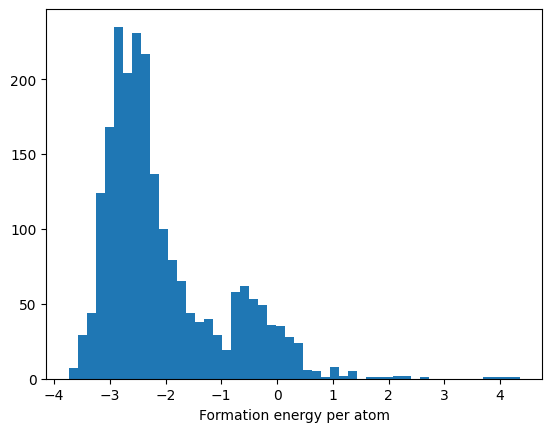

In [13]:
# Histogramas: label 0
plt.figure(1)
plt.hist(cluster0["volume"],bins=50)
plt.xlabel("Volume")
plt.show()

plt.figure(2)
plt.hist(cluster0["formation_energy_per_atom"],bins=50)
plt.xlabel("Formation energy per atom")
plt.show()

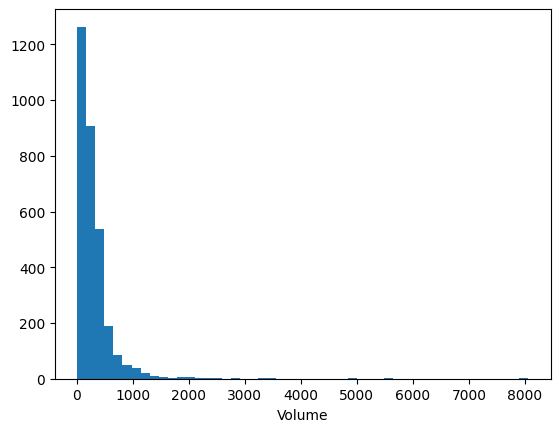

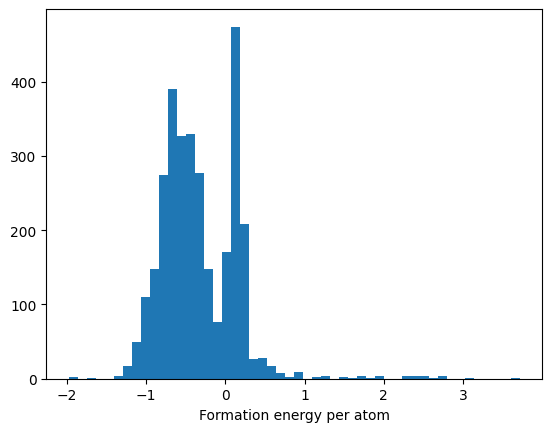

In [14]:
# Histogramas: label 1
plt.figure(1)
plt.hist(cluster1["volume"],bins=50)
plt.xlabel("Volume")
plt.show()

plt.figure(2)
plt.hist(cluster1["formation_energy_per_atom"],bins=50)
plt.xlabel("Formation energy per atom")
plt.show()

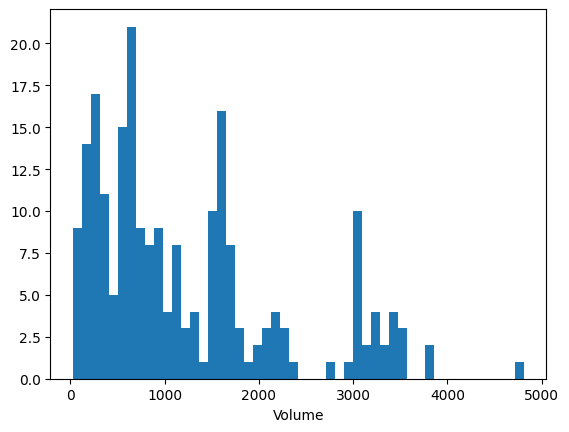

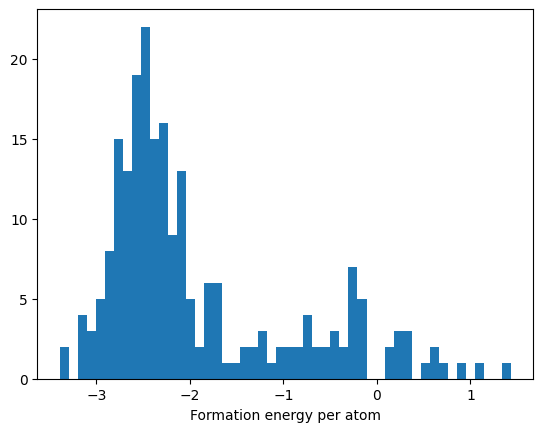

In [15]:
# Histogramas: label 2
plt.figure(1)
plt.hist(cluster2["volume"],bins=50)
plt.xlabel("Volume")
plt.show()

plt.figure(2)
plt.hist(cluster2["formation_energy_per_atom"],bins=50)
plt.xlabel("Formation energy per atom")
plt.show()

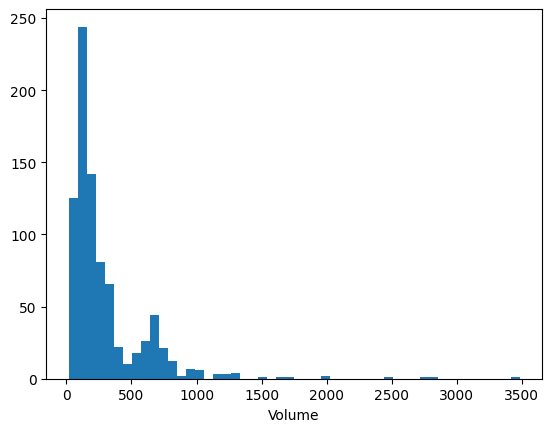

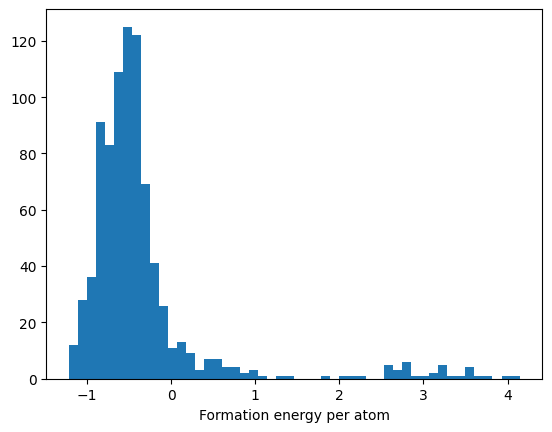

In [16]:
# Histogramas: label 3
plt.figure(1)
plt.hist(cluster3["volume"],bins=50)
plt.xlabel("Volume")
plt.show()

plt.figure(2)
plt.hist(cluster3["formation_energy_per_atom"],bins=50)
plt.xlabel("Formation energy per atom")
plt.show()